# MAC address

Predict the category (mobile, desktop) from a device mac address.

In [1]:
## Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## The data

In [2]:
with open('database.json', 'rb') as f:
    lines = f.read()
dic = eval(lines)

### Inspect the data

In [ ]:
n = 10
first_ten_pairs = {k: dic[k] for k in dic.keys()[:10]}

### Data processing

In [4]:
# Get into a format usable by pandas
data_list = []
for k in dic.keys():
    for value_list in dic[k]:
        row = [k] + value_list
        data_list.append(row)
        
print "There are %d records in the dataset" % len(data_list)

There are 78032 records in the dataset


In [5]:
columns=['OUI','mac_hexa','mac_string','OS']
df = pd.DataFrame(data_list,columns=columns)

In [6]:
df.OS.unique()

array(['Android', 'iOS', 'Windows 8', 'Windows 7/Vista', 'Mac OS X',
       'Windows', ' Android', 'Debian-based Linux', 'Nexus', ' LP',
       'Cisco/Linksys Router', 'Eye-Fi Wireless Memory Card', 'Nokia',
       'Samsung Network Printer', 'Generic Linux', 'Linux', 'BlackBerry',
       'Xbox 360', ' L.P.', 'Ellipsis 8', 'HP Printer', 'Sony handset',
       ' LED.', 'Windows XP', 'Chrome OS'], dtype=object)

### Clean data

With some help from http://standards-oui.ieee.org/oui.txt

In [7]:
df['category'] = 0
df['type'] = df.OS

# Mobile category
df.loc[df.OS.str.contains('Android'),'category'] = 'mobile'
df.loc[df.OS.str.contains('Android'),'type'] = 'Android'

df.loc[df.OS.str.contains('iOS'),'category'] = 'mobile'
df.loc[df.OS.str.contains('Nokia'),'category'] = 'mobile'
df.loc[df.OS.str.contains('Ellipsis 8'),'category'] = 'mobile'
df.loc[df.OS.str.contains('BlackBerry'),'category'] = 'mobile'
df.loc[df.OS.str.contains('Nexus'),'category'] = 'mobile'
df.loc[df.OS.str.contains('Sony handset'),'category'] = 'mobile'

# Desktop category
df.loc[df.OS.str.contains('Linux'),'category'] = 'desktop'
df.loc[df.OS.str.contains('Linux'),'type'] = 'Linux'
df.loc[df.OS.str.contains('Windows'),'category'] = 'desktop'
df.loc[df.OS.str.contains('Windows'),'type'] = 'Windows'

df.loc[df.OS.str.contains('Mac OS'),'category'] = 'desktop'
df.loc[df.OS.str.contains('Mac OS'),'type'] = 'MacOS'
df.loc[df.OS.str.contains('Xbox 360'),'category'] = 'desktop'
df.loc[df.OS.str.contains('Chrome OS'),'category'] = 'desktop'

df.loc[df.OS.str.contains('LP'),'category'] = 'desktop'
df.loc[df.OS.str.contains(' L.P.'),'category'] = 'desktop'
df.loc[df.OS.str.contains('LP'),'type'] = 'LP'
df.loc[df.OS.str.contains(' L.P.'),'type'] = 'LP'

df.loc[df.OS.str.contains('LED'),'category'] = 'desktop'
df.loc[df.OS.str.contains('LED'),'type'] = 'LED'

df.loc[df.OS.str.contains('Router'),'category'] = 'desktop'
df.loc[df.OS.str.contains('Router'),'type'] = 'Router'
df.loc[df.OS.str.contains('Printer'),'category'] = 'desktop'
df.loc[df.OS.str.contains('Printer'),'type'] = 'Printer'
df.loc[df.OS.str.contains('Eye-Fi Wireless Memory Card'),'category'] = 'desktop'


df['output'] = df.apply(lambda x: 0 if x['category'] == 'mobile' else 1,axis=1)

df.to_csv('data.csv', index=False)

In [8]:
df.head()

,OUI,mac_hexa,mac_string,OS,category,type,output
0,f40e22,268341551822999,f40e22dff897,Android,mobile,Android,0
1,b49cdf,198585860555195,b49cdfad01bb,iOS,mobile,iOS,0
2,b49cdf,198585862571231,b49cdfcbc4df,iOS,mobile,iOS,0
3,b49cdf,198585862571275,b49cdfcbc50b,iOS,mobile,iOS,0
4,80ea96,141745039628824,80ea96bc5a18,iOS,mobile,iOS,0


## Balance of the dataset

If the dataset is unbalanced, the model won't perform well on real-world data.

In [9]:
mobile = df.loc[df['output'] == 0,'output'].value_counts()
desktop = df.loc[df['output'] == 1,'output'].value_counts()
total = mobile.values[0]+desktop.values[0]

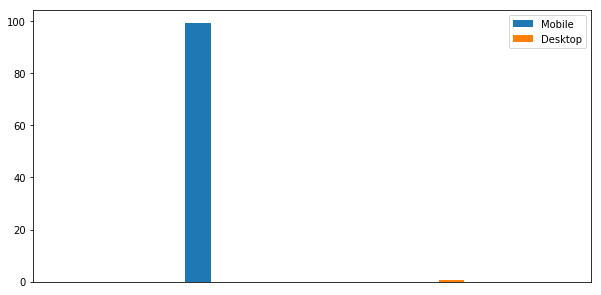

The dataset consists of 99.20% of mobile and 0.80% of desktop.


In [10]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
mobile_series = df.loc[df['output'] == 0,'output']
desktop_series = df.loc[df['output'] == 1,'output']
plt.hist(mobile_series,label='Mobile', weights=np.zeros_like(mobile_series) + 1. / total *100 )
plt.hist(desktop_series,label='Desktop', weights=np.zeros_like(desktop_series) + 1. / total *100 )
ax.axes.get_xaxis().set_visible(False)
plt.legend()
plt.show()

print "The dataset consists of %.2f%% of mobile and %.2f%% of desktop." % (mobile.values[0]/float(total)*100, desktop.values[0]/float(total)*100)

In [11]:
df.type.value_counts()/df.shape[0]*100

Android                        96.889738
iOS                             2.170904
MacOS                           0.363953
Windows                         0.356264
Nexus                           0.129434
Linux                           0.055106
LED                             0.006408
Nokia                           0.005126
Router                          0.003845
Ellipsis 8                      0.003845
Printer                         0.003845
LP                              0.002563
Xbox 360                        0.002563
BlackBerry                      0.002563
Chrome OS                       0.001282
Sony handset                    0.001282
Eye-Fi Wireless Memory Card     0.001282
Name: type, dtype: float64

### Conclusion
The data is clearly unbalanced. We need to tweak the dataset to be able to predict something useful.

Two possibilities:
- since the OUI is manufacturer-independent and only a few manufacturers have mobile and desktop devices, concentrate on dual category manufacturers
    - Pro: will perform well on the dual category manufacturers OUI
    - Con: won't be able to generalize from other manufacturers OUI
- rebalance the dataset by add weight to classes:
    - Pro: will model all the OUI in the dataset
    - Con: might take more times to model

## 1. First model: dual categories manufacturers

### OUI with several categories

In [12]:
s_df = df.groupby('OUI').agg(lambda x: set(x))['category']

shared_cat = []
for key in s_df.keys():
    if len(s_df[key]) > 1:
        shared_cat.append(key)
print shared_cat

['1040f3', '24f094', '2cf0ee', '34363b', '3c15c2', '48bf6b', '48d705', '4c3275', '600308', '60128b', '60c547', '60f81d', '6476ba', '6c4008', '7831c1', '784f43', '7c04d0', '80e650', '843835', '8c2937', '90fd61', '9801a7', '98e0d9', '98fe94', 'a0999b', 'a45e60', 'a8667f', 'ac293a', 'acbc32', 'b8e856', 'c4b301', 'd0a637', 'e0accb', 'e4ce8f', 'f07960', 'f40f24', 'f45c89']


In [ ]:
df_shared_cat = df[df['OUI'].isin(shared_cat)]
df_shared_cat.head()

In [14]:
mobile = df_shared_cat.loc[df_shared_cat['output'] == 0,'output'].value_counts()
desktop = df_shared_cat.loc[df_shared_cat['output'] == 1,'output'].value_counts()
total = mobile.values[0]+desktop.values[0]

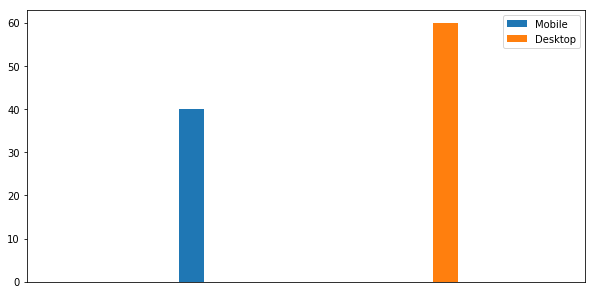

The dataset consists of 40.06% of mobile and 59.94% of desktop.


In [15]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
mobile_series = df_shared_cat.loc[df['output'] == 0,'output']
desktop_series = df_shared_cat.loc[df['output'] == 1,'output']
plt.hist(mobile_series,label='Mobile', weights=np.zeros_like(mobile_series) + 1. / total *100 )
plt.hist(desktop_series,label='Desktop', weights=np.zeros_like(desktop_series) + 1. / total *100 )
ax.axes.get_xaxis().set_visible(False)
plt.legend()
plt.show()

print "The dataset consists of %.2f%% of mobile and %.2f%% of desktop." % (mobile.values[0]/float(total)*100, desktop.values[0]/float(total)*100)

## Features

In [16]:
df_ml = df_shared_cat.copy()

In [17]:
df_ml['oui_dec'] = df_ml.apply(lambda x: int(x['OUI'],16),axis=1)
df_ml['mac_wo_oui'] = df_ml.apply(lambda x: int(x['mac_string'][6:],16),axis=1)
df_ml['mac_wo_oui_1'] = df_ml.apply(lambda x: int(x['mac_string'][6:8],16),axis=1)
df_ml['mac_wo_oui_2'] = df_ml.apply(lambda x: int(x['mac_string'][8:10],16),axis=1)
df_ml['mac_wo_oui_3'] = df_ml.apply(lambda x: int(x['mac_string'][10:12],16),axis=1)

In [ ]:
df_ml.tail()

# Model

In [19]:
# split data into X and y
x_train = pd.DataFrame()
x_train['oui_dec'] = df_ml['oui_dec']
x_train['mac_hexa'] = df_ml['mac_hexa']
x_train['mac_wo_oui'] = df_ml['mac_wo_oui']
x_train['mac_wo_oui_1'] = df_ml['mac_wo_oui_1']
x_train['mac_wo_oui_2'] = df_ml['mac_wo_oui_2']
x_train['mac_wo_oui_3'] = df_ml['mac_wo_oui_3']

y_train = df_ml['output'].values

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Split data into train and test sets
seed = 7
test_size = 0.33

x_train_set, x_test_set, y_train_set, y_test_set = train_test_split(
    x_train, y_train, test_size=test_size, random_state=seed)

print('Total number of positive train instances: {}'.format(y_train_set.sum()))
print('Total number of positive test instances: {}'.format(y_test_set.sum()))

# Model parameter
params = {}
params['objective'] = 'binary:logistic' # binary output
params['eval_metric'] = 'logloss' # validation metrics
params['eta'] = 0.04 # learning rate, default 0.03
params['max_depth'] = 3 # Less over-fitting, default = 6

Total number of positive train instances: 147
Total number of positive test instances: 67


In [21]:
import xgboost as xgb

d_train = xgb.DMatrix(x_train_set, label=y_train_set)
d_test = xgb.DMatrix(x_test_set, label=y_test_set)

watchlist  = [(d_test,'eval'), (d_train,'train')]
num_round = 5001
bst = xgb.train(params, d_train, num_round, watchlist, verbose_eval=1000)

bst.save_model('xgb_model_dual_cat.mdl')

[0]	eval-logloss:0.68464	train-logloss:0.681757


/Users/matt/.virtualenvs/quora/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[1000]	eval-logloss:0.588023	train-logloss:0.150374
[2000]	eval-logloss:0.697925	train-logloss:0.070733
[3000]	eval-logloss:0.767437	train-logloss:0.050269
[4000]	eval-logloss:0.799437	train-logloss:0.043557
[5000]	eval-logloss:0.816715	train-logloss:0.039452


In [22]:
y_test_preds = (bst.predict(d_test) > 0.5).astype('int')

pd.crosstab(
    pd.Series(y_test_set, name='Actual'),
    pd.Series(y_test_preds, name='Predicted'),
    margins=True
)

Predicted,0,1,All
Actual,,,
0,32,19,51
1,16,51,67
All,48,70,118


In [23]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test_set, y_test_preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test_set, y_test_preds)))
print('Recall: {0:.2f}'.format(recall_score(y_test_set, y_test_preds)))

Accuracy: 0.70
Precision: 0.73
Recall: 0.76


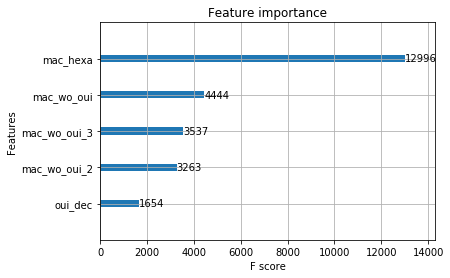

In [24]:
xgb.plot_importance(bst)

## Test with new data

### Small dataset

In [ ]:
df_test = pd.read_csv('test_data.csv').fillna("")
df_test

In [26]:
x_test = pd.DataFrame()
x_test['oui_dec'] = df_test.apply(lambda x: int(x['OUI'],16),axis=1)
x_test['mac_hexa'] = df_test['mac_hexa']
x_test['mac_wo_oui'] = df_test.apply(lambda x: int(x['mac_string'][6:],16),axis=1)
x_test['mac_wo_oui_1'] = df_test.apply(lambda x: int(x['mac_string'][6:8],16),axis=1)
x_test['mac_wo_oui_2'] = df_test.apply(lambda x: int(x['mac_string'][8:10],16),axis=1)
x_test['mac_wo_oui_3'] = df_test.apply(lambda x: int(x['mac_string'][10:12],16),axis=1)

In [27]:
bst = xgb.Booster(params)
bst.load_model('xgb_model.mdl')

d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

In [28]:
final = pd.DataFrame()
final['OS'] = df_test['OS']
final['category'] = df_test['category']
final['predicted_output'] = ['desktop' if x > 0.5 else 'mobile' for x in p_test ]
final['correct'] = final.apply(lambda x: x['category'] == x['predicted_output'],axis=1)
accuracy = final['correct'].value_counts()[True]/(float(final.shape[0]))*100

print "The accuracy of the prediction is %.2f%%" % accuracy

The accuracy of the prediction is 100.00%


In [29]:
final

,OS,category,predicted_output,correct
0,Mac OS,desktop,desktop,True
1,iOS,mobile,mobile,True
2,Linux,desktop,desktop,True
3,Mac OS,desktop,desktop,True
4,iOS,mobile,mobile,True
5,iOS,mobile,mobile,True
6,Android,mobile,mobile,True


We can see that the classifier performed well on our self-gathered dataset. 
Let's try on non dual dataset to see if the model generalizes or not.

### Larger dataset

In [30]:
# Gather samples from non-dual manufacturers
df_tmp = df[~df['OUI'].isin(shared_cat)]
df_tmp.head()

df_tmp_pos = df_tmp[df_tmp['output'] == 1].sample(frac=0.3, replace=False)
df_tmp_neg = df_tmp[df_tmp['output'] == 0].sample(frac=0.008, replace=False)

df_large = pd.concat([df_tmp_pos, df_tmp_neg], ignore_index=True)
df_large.head()

df_large = df_tmp.copy()

In [31]:
x_test = pd.DataFrame()
x_test['oui_dec'] = df_large.apply(lambda x: int(x['OUI'],16),axis=1)
x_test['mac_hexa'] = df_large['mac_hexa']
x_test['mac_wo_oui'] = df_large.apply(lambda x: int(x['mac_string'][6:],16),axis=1)
x_test['mac_wo_oui_1'] = df_large.apply(lambda x: int(x['mac_string'][6:8],16),axis=1)
x_test['mac_wo_oui_2'] = df_large.apply(lambda x: int(x['mac_string'][8:10],16),axis=1)
x_test['mac_wo_oui_3'] = df_large.apply(lambda x: int(x['mac_string'][10:12],16),axis=1)

In [32]:
bst = xgb.Booster(params)
bst.load_model('xgb_model_dual_cat.mdl')

d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

In [33]:
final = pd.DataFrame()
final['OS'] = df_large['OS']
final['category'] = df_large['category']
final['predicted_output'] = ['desktop' if x > 0.5 else 'mobile' for x in p_test ]
final['correct'] = final.apply(lambda x: x['category'] == x['predicted_output'],axis=1)
accuracy = final['correct'].value_counts()[True]/(float(final.shape[0]))*100

print "The accuracy of the prediction is %.2f%%" % accuracy 

The accuracy of the prediction is 31.53%


### Conclusion

The model doesn't perform well on the non-dual manufacturers dataset. 
The reason why the it performed well on the self-gathered dataset is because it is made up of mostly Apple devices which make most of the model train samples.

## 2. Second model: Rebalance the dataset

By add weight to classes, the model will be more balanced and be able to learn efficiently about the classes.

In [34]:
df_ml = df.copy()

In [35]:
df_ml['oui_dec'] = df_ml.apply(lambda x: int(x['OUI'],16),axis=1)
df_ml['mac_wo_oui'] = df_ml.apply(lambda x: int(x['mac_string'][6:],16),axis=1)
df_ml['mac_wo_oui_1'] = df_ml.apply(lambda x: int(x['mac_string'][6:8],16),axis=1)
df_ml['mac_wo_oui_2'] = df_ml.apply(lambda x: int(x['mac_string'][8:10],16),axis=1)
df_ml['mac_wo_oui_3'] = df_ml.apply(lambda x: int(x['mac_string'][10:12],16),axis=1)

In [36]:
# split data into X and y
x_train = pd.DataFrame()
x_train['oui_dec'] = df_ml['oui_dec']
x_train['mac_hexa'] = df_ml['mac_hexa']
x_train['mac_wo_oui'] = df_ml['mac_wo_oui']
x_train['mac_wo_oui_1'] = df_ml['mac_wo_oui_1']
x_train['mac_wo_oui_2'] = df_ml['mac_wo_oui_2']
x_train['mac_wo_oui_3'] = df_ml['mac_wo_oui_3']

y_train = df_ml['output'].values

In [37]:
# Split data into train and test sets
seed = 7
test_size = 0.33

x_train_set, x_test_set, y_train_set, y_test_set = train_test_split(
    x_train, y_train, test_size=test_size, random_state=seed)

print('Total number of positive train instances: {}'.format(y_train_set.sum()))
print('Total number of positive test instances: {}'.format(y_test_set.sum()))

# Model parameter
params = {}
params['objective'] = 'binary:logistic' # binary output
params['eval_metric'] = 'logloss' # validation metrics
params['eta'] = 0.04 # learning rate, default 0.03
params['max_depth'] = 3 # Less over-fitting, default = 6

Total number of positive train instances: 408
Total number of positive test instances: 214


In [38]:
d_train = xgb.DMatrix(x_train_set, label=y_train_set)
d_test = xgb.DMatrix(x_test_set, label=y_test_set)

train_labels = d_train.get_label()

ratio = float(np.sum(train_labels == 0)) / np.sum(train_labels == 1)
params['scale_pos_weight'] = ratio

In [39]:
watchlist  = [(d_test,'eval'), (d_train,'train')]
num_round = 5001
bst = xgb.train(params, d_train, num_round, watchlist, verbose_eval=1000)

bst.save_model('xgb_model_unbalanced.mdl')

[0]	eval-logloss:0.674448	train-logloss:0.674425
[1000]	eval-logloss:0.075236	train-logloss:0.072498
[2000]	eval-logloss:0.053974	train-logloss:0.047801
[3000]	eval-logloss:0.04618	train-logloss:0.038416
[4000]	eval-logloss:0.042799	train-logloss:0.034371
[5000]	eval-logloss:0.041537	train-logloss:0.032124


In [40]:
y_test_preds = (bst.predict(d_test) > 0.5).astype('int')

pd.crosstab(
    pd.Series(y_test_set, name='Actual'),
    pd.Series(y_test_preds, name='Predicted'),
    margins=True
)

Predicted,0,1,All
Actual,,,
0,25269,268,25537
1,38,176,214
All,25307,444,25751


In [41]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test_set, y_test_preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test_set, y_test_preds)))
print('Recall: {0:.2f}'.format(recall_score(y_test_set, y_test_preds)))

Accuracy: 0.99
Precision: 0.40
Recall: 0.82


Using weight to rebalance the model seems to pay off.

## Small dataset

In [42]:
df_test = pd.read_csv('test_data.csv').fillna("")
x_test = pd.DataFrame()

x_test['oui_dec'] = df_test.apply(lambda x: int(x['OUI'],16),axis=1)
x_test['mac_hexa'] = df_test['mac_hexa']
x_test['mac_wo_oui'] = df_test.apply(lambda x: int(x['mac_string'][6:],16),axis=1)
x_test['mac_wo_oui_1'] = df_test.apply(lambda x: int(x['mac_string'][6:8],16),axis=1)
x_test['mac_wo_oui_2'] = df_test.apply(lambda x: int(x['mac_string'][8:10],16),axis=1)
x_test['mac_wo_oui_3'] = df_test.apply(lambda x: int(x['mac_string'][10:12],16),axis=1)

bst = xgb.Booster(params)
bst.load_model('xgb_model.mdl')

d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

In [43]:
final = pd.DataFrame()
final['OS'] = df_test['OS']
final['category'] = df_test['category']
final['predicted_output'] = ['desktop' if x > 0.5 else 'mobile' for x in p_test ]
final['correct'] = final.apply(lambda x: x['category'] == x['predicted_output'],axis=1)
accuracy = final['correct'].value_counts()[True]/(float(final.shape[0]))*100

print "The accuracy of the prediction is %.2f%%" % accuracy

The accuracy of the prediction is 100.00%


In [44]:
final

,OS,category,predicted_output,correct
0,Mac OS,desktop,desktop,True
1,iOS,mobile,mobile,True
2,Linux,desktop,desktop,True
3,Mac OS,desktop,desktop,True
4,iOS,mobile,mobile,True
5,iOS,mobile,mobile,True
6,Android,mobile,mobile,True


In [45]:
x_test = pd.DataFrame()

x_test['oui_dec'] = df_large.apply(lambda x: int(x['OUI'],16),axis=1)
x_test['mac_hexa'] = df_large['mac_hexa']
x_test['mac_wo_oui'] = df_large.apply(lambda x: int(x['mac_string'][6:],16),axis=1)
x_test['mac_wo_oui_1'] = df_large.apply(lambda x: int(x['mac_string'][6:8],16),axis=1)
x_test['mac_wo_oui_2'] = df_large.apply(lambda x: int(x['mac_string'][8:10],16),axis=1)
x_test['mac_wo_oui_3'] = df_large.apply(lambda x: int(x['mac_string'][10:12],16),axis=1)

bst = xgb.Booster(params)
bst.load_model('xgb_model_unbalanced.mdl')

d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

### Conclusion
The rebalanced model seems to work fine with unknown data. It needs to be further tested with larger unknown dataset.